In [1]:
import numpy as np
from tensorflow import keras
from sklearn import preprocessing

# Load labels 

train_labels=np.load("train_labels.npy")
val_labels=np.load("val_labels.npy")
test_labels=np.load("test_labels.npy")

num_classes = len(np.unique(train_labels))
print('Total classes: ',num_classes)

# Encodes labels to categorical

le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_num = le.transform(train_labels)
val_labels_num = le.transform(val_labels)
test_labels_num = le.transform(test_labels)

train_labels_bin = keras.utils.to_categorical(train_labels_num, num_classes)
val_labels_bin = keras.utils.to_categorical(val_labels_num, num_classes)
test_labels_bin = keras.utils.to_categorical(test_labels_num, num_classes)



Total classes:  29


In [2]:
from utils.ExpConfiguration import *
from utils.modelUtils import *
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


padd = 'new' # CHANGE HERE to select other padding schemas (new, constant, random)

en = seqEncoders[1] # CHANGE HERE to select different encoders


batch_size = 32
epochs = 10

nl = 3
bn = 0

print('n. layers=',nl,' Encoder=',en['filename'],' Noise=',str(bn), ' Padding=',padd)
train_seq=np.load('train_' + en['filename'] + '_' + padd + '_' + str(bn) + '_seq.npy')
val_seq=np.load('val_' + en['filename'] + '_' + padd + '_' + str(bn) + '_seq.npy')
test_seq=np.load('test_' + en['filename'] + '_' + padd + '_' + str(bn) + '_seq.npy')

train_seq = keras.utils.to_categorical(train_seq)
val_seq = keras.utils.to_categorical(val_seq)
test_seq = keras.utils.to_categorical(test_seq)

if (en['filename'] in ['1mer','2mer','3mer']):
    m=buildCNNModel(inshape=train_seq.shape[1:],num_classes=num_classes,nlayers=nl,cnndim=1)
else:
    m=buildCNNModel(inshape=train_seq.shape[1:],num_classes=num_classes,nlayers=nl,cnndim=2)

print(m.summary())

m.compile(optimizer=keras.optimizers.Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

m.fit(train_seq, train_labels_bin,verbose=1,
                  batch_size=batch_size,shuffle=True,
                  epochs=epochs,#validation_split=0.33,
                  validation_data=(val_seq, val_labels_bin))

#pred = m.predict(test_seq, verbose=1)
#predicted = np.argmax(pred, axis=1)


n. layers= 3  Encoder= 2mer  Noise= 0  Padding= new
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 75, 32)            1664      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 37, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 64)            0         
___________________________________

In [4]:
import tensorflow.keras.backend as K

#If you set the learning_phase to 0 you turn the dropout at test time off and if you set it to 1, it on 
model_mc = K.function([m.input, K.learning_phase()], [m.output])

In [5]:
from utils.ExpConfiguration import *
from utils.modelUtils import *

testfile = 'test_rndseq_t1.fasta'
test_labels_rnd = get_labels(testfile)

seqTestRnd = get_seqs_with_bnoise(testfile,nperc=0)
test_seq_rnd = encode_seqs(seqTestRnd,enc=en['enc'],encparam=en['param'+str(bn)],padding=padd)

test_seq_rnd = keras.utils.to_categorical(test_seq_rnd)



 Done 14530 total records


In [138]:


mc = 50

avrp_rnd = np.zeros((len(test_seq_rnd),num_classes))
avrp_nornd = np.zeros((len(test_seq),num_classes))

fp_rnd = np.zeros((len(test_seq_rnd),num_classes))
fp_nornd = np.zeros((len(test_seq),num_classes))


for i in range(mc):
    preds_nornd=model_mc([test_seq,1])
    avrp_nornd = avrp_nornd + preds_nornd[0]
    midx = np.argmax(preds_nornd[0],1)
    for j in range(len(test_seq)):
        fp_nornd[j,midx[j]] = fp_nornd[j,midx[j]] + 1

    preds_rnd=model_mc([test_seq_rnd,1])
    avrp_rnd = avrp_rnd + preds_rnd[0]
    midx = np.argmax(preds_rnd[0],1)
    for j in range(len(test_seq_rnd)):
        fp_rnd[j,midx[j]] = fp_rnd[j,midx[j]] + 1


avrp_rnd = avrp_rnd/mc
avrp_nornd = avrp_nornd/mc
fp_rnd = fp_rnd/mc
fp_nornd = fp_nornd/mc
maxp_train = maxp_train/mc

In [139]:

hp_nornd = np.sum(-avrp_nornd*np.log2(avrp_nornd+1e-10),1)
hp_rnd = np.sum(-avrp_rnd*np.log2(avrp_rnd+1e-10),1)


avrp_nornd = np.max(avrp_nornd,1)
avrp_rnd = np.max(avrp_rnd,1)
fp_nornd = np.max(fp_nornd,1)
fp_rnd = np.max(fp_rnd,1)






In [140]:
hp_nornd.shape


(14530,)

array([[1.00000000e+00, 3.90354079e-32, 4.15146763e-30, ...,
        4.06675323e-27, 7.28510762e-30, 5.82653722e-33],
       [1.06179556e-04, 1.67984410e-07, 3.33553588e-04, ...,
        2.21686569e-05, 1.07146414e-04, 4.30071494e-03],
       [4.99509136e-15, 1.15093435e-10, 3.06396090e-16, ...,
        2.49168894e-21, 1.42570680e-15, 8.06477094e-15],
       ...,
       [8.36268127e-01, 1.50565276e-04, 1.88884550e-11, ...,
        3.53970172e-05, 1.72519358e-05, 6.34235505e-04],
       [1.00000000e+00, 2.71963626e-18, 1.04133218e-22, ...,
        8.79668050e-21, 2.88392123e-22, 1.69795100e-16],
       [3.06730483e-16, 5.59573933e-19, 1.17420530e-21, ...,
        9.30372391e-23, 3.14822067e-18, 9.97203708e-01]], dtype=float32)

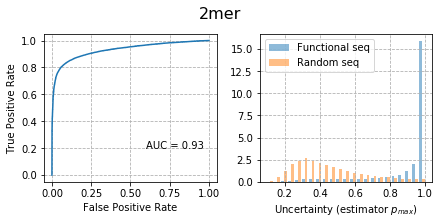

In [145]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


pred_score = np.concatenate([avrp_nornd, avrp_rnd])
true_class = np.concatenate([np.ones(len(avrp_nornd)), np.zeros(len(avrp_rnd))])

ns_auc = roc_auc_score(true_class, pred_score)
ns_fpr, ns_tpr, _ = roc_curve(true_class, pred_score)


fig, axs = pyplot.subplots(1, 2, constrained_layout=True,figsize=(6,3))
fig.suptitle(en['filename'], fontsize=16)

#pyplot.figure(figsize=(6,3))
axs[0].plot(ns_fpr, ns_tpr, linestyle='-')
axs[0].text(0.6, 0.2, 'AUC = %.2f' % ns_auc)
axs[0].grid(linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')

axs[1].hist([avrp_nornd, avrp_rnd], bins='auto', density=True, alpha=0.5, label=['Functional seq', 'Random seq'])

axs[1].legend(loc='upper left')
axs[1].grid(linestyle='--')
axs[1].set_xlabel(r'Uncertainty (estimator $p_{max}$)')
#
pyplot.savefig('figs/plot_rejection_avrp_'+en['filename']+'.pdf')
pyplot.show()

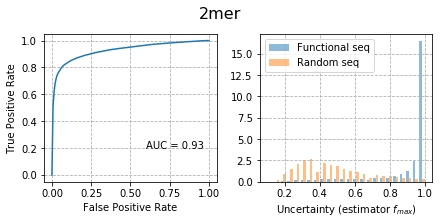

In [146]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


pred_score = np.concatenate([fp_nornd, fp_rnd])
true_class = np.concatenate([np.ones(len(fp_nornd)), np.zeros(len(fp_rnd))])

ns_auc = roc_auc_score(true_class, pred_score)
ns_fpr, ns_tpr, _ = roc_curve(true_class, pred_score)


fig, axs = pyplot.subplots(1, 2, constrained_layout=True,figsize=(6,3))
fig.suptitle(en['filename'], fontsize=16)

#pyplot.figure(figsize=(6,3))
axs[0].plot(ns_fpr, ns_tpr, linestyle='-')
axs[0].text(0.6, 0.2, 'AUC = %.2f' % ns_auc)
axs[0].grid(linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')

axs[1].hist([fp_nornd, fp_rnd], bins='auto', density=True, alpha=0.5, label=['Functional seq', 'Random seq'])

axs[1].legend(loc='upper left')
axs[1].grid(linestyle='--')
axs[1].set_xlabel(r'Uncertainty (estimator $f_{max}$)')
#
pyplot.savefig('figs/plot_rejection_fp_'+en['filename']+'.pdf')
pyplot.show()

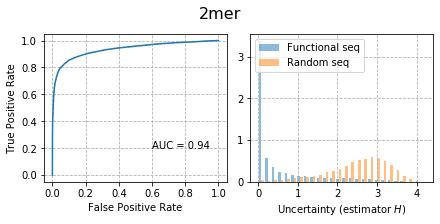

In [147]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


pred_score = np.concatenate([-hp_nornd, -hp_rnd])
true_class = np.concatenate([np.ones(len(hp_nornd)), np.zeros(len(hp_rnd))])

ns_auc = roc_auc_score(true_class, pred_score)
ns_fpr, ns_tpr, _ = roc_curve(true_class, pred_score)


fig, axs = pyplot.subplots(1, 2, constrained_layout=True,figsize=(6,3))
fig.suptitle(en['filename'], fontsize=16)

#pyplot.figure(figsize=(6,3))
axs[0].plot(ns_fpr, ns_tpr, linestyle='-')
axs[0].text(0.6, 0.2, 'AUC = %.2f' % ns_auc)
axs[0].grid(linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')

axs[1].hist([hp_nornd, hp_rnd], bins='auto', density=True, alpha=0.5, label=['Functional seq', 'Random seq'])

axs[1].legend(loc='upper left')
axs[1].grid(linestyle='--')
axs[1].set_xlabel(r'Uncertainty (estimator $H$)')
#
pyplot.savefig('figs/plot_rejection_H_'+en['filename']+'.pdf')
pyplot.show()